### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import T, accuracy_score, mean_squared_error

## Load dataset

In [ ]:
data_path = '/content/drive/MyDrive/AIL303m _ AI1901 _ Nguyễn Gia Hiển _ Final project/dataset/data.csv'
label_path = '/content/drive/MyDrive/AIL303m _ AI1901 _ Nguyễn Gia Hiển _ Final project/dataset/label.csv'

In [ ]:
x = pd.read_csv(data_path, header=None)
y = pd.read_csv(label_path, header=None)

## Data Describe

- About dataset :
  - This dataset is generated by myself, not collected from any source.
  - About `10.000` Minesweeper boards is generated. The goal of the model is to predict if the cell contains mine or not.
  - The board is numerically convert, `numbered cells` remain its number, `hidden cells` will be `-0.5`, `flagged cells` will be `-1`, `mine cells` will be `-2` and the `border` will be `-10`.
  - Each sample(row) of the dataset contain 27 features(cols) :
    - The first feature is the number of the current cell.
    - The next 24 cells are the neighboring cell values ​​surrounding the current cell.
    - The last two features are the number of hidden cells surrounding the current cell and the number of flagged cells surrounding the current cell respectively.

- Assume a 5x5 board :


```
0  0  0  0  0         0    0    0    0   0             0   0   0   0   0
0  1  1  1  0         0    1    1    1   0             0   1   1   1   0
0  1  ?  1  0     ->  0    1  -0.5   1   0    y_true : 0   1   M   1   0
0  1  ?  ?  0         0    1  -0.5 -0.5  0             0   1   1   1   0
?  ?  ?  ?  ?      -0.5  -0.5 -0.5 -0.5 -0.5           0   1   0   0   1


let take the cell at position (2, 2), extract features of that cell we have:
- Feature X :     
+----------+----------+----------+----------+...+----------+----------+---------+
|number of |neighbor1 |neighbor2 |neighbor3 |...|neighbor24| #hiddens |#flags   |
|the cell  |          |          |          |...|          |          |         |
+----------+----------+----------+----------+...+----------+----------+---------+
| -0.5     |     0    |    0     |     0    |...|    -0.5  |     7    |    0    |
+----------+----------+----------+----------+...+----------+----------+---------+

- Label y : 1 (Mine)
```

In [ ]:
x.head(), y.head()

(    0     1     2     3     4     5     6     7     8     9   ...    17   18  \
 0 -0.5 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0  ... -10.0 -0.5   
 1 -0.5 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0  ...  -0.5 -0.5   
 2 -0.5 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0  ...  -0.5 -0.5   
 3 -0.5 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0  ...  -0.5 -0.5   
 4 -0.5 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0  ...  -0.5 -0.5   
 
     19    20    21    22   23   24    25   26  
 0 -0.5 -10.0 -10.0 -10.0 -0.5 -0.5   4.0  0.0  
 1 -0.5 -10.0 -10.0  -0.5 -0.5 -0.5   6.0  0.0  
 2 -0.5 -10.0  -0.5  -0.5 -0.5 -0.5   8.0  0.0  
 3 -0.5  -0.5  -0.5  -0.5 -0.5 -0.5  10.0  0.0  
 4 -0.5  -0.5  -0.5  -0.5 -0.5 -0.5  10.0  0.0  
 
 [5 rows x 27 columns],
    0
 0  0
 1  0
 2  0
 3  0
 4  1)

In [ ]:
x.describe()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
count,810000.000000,810000.000000,810000.000000,810000.00000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,...,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000
mean,0.095867,-5.480759,-4.724478,-3.97246,-3.245806,-3.972623,-4.723998,-3.841076,-2.963419,-2.115526,...,-0.992344,0.095867,-0.992699,-3.973306,-2.964722,-1.962075,-0.992878,-1.962409,5.504942,1.286386
std,0.827094,5.084633,5.121114,5.04168,4.825067,5.041535,5.121696,5.022480,4.756674,4.280167,...,3.283791,0.827094,3.283623,5.040987,4.755704,4.214351,3.283598,4.214146,4.919378,1.045598
min,-1.000000,-10.000000,-10.000000,-10.00000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-1.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,0.000000,0.000000
25%,-0.500000,-10.000000,-10.000000,-10.00000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-1.000000,...,-0.500000,-0.500000,-0.500000,-10.000000,-10.000000,-1.000000,-0.500000,-1.000000,1.000000,0.000000
50%,0.000000,-10.000000,-1.000000,-0.50000,-0.500000,-0.500000,-1.000000,-0.500000,-0.500000,-0.500000,...,0.000000,0.000000,0.000000,-0.500000,-0.500000,-0.500000,0.000000,-0.500000,5.000000,1.000000
75%,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.000000,2.000000
max,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,24.000000,7.000000


In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810000 entries, 0 to 809999
Data columns (total 27 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       810000 non-null  float64
 1   1       810000 non-null  float64
 2   2       810000 non-null  float64
 3   3       810000 non-null  float64
 4   4       810000 non-null  float64
 5   5       810000 non-null  float64
 6   6       810000 non-null  float64
 7   7       810000 non-null  float64
 8   8       810000 non-null  float64
 9   9       810000 non-null  float64
 10  10      810000 non-null  float64
 11  11      810000 non-null  float64
 12  12      810000 non-null  float64
 13  13      810000 non-null  float64
 14  14      810000 non-null  float64
 15  15      810000 non-null  float64
 16  16      810000 non-null  float64
 17  17      810000 non-null  float64
 18  18      810000 non-null  float64
 19  19      810000 non-null  float64
 20  20      810000 non-null  float64
 21  21      81

<Axes: >

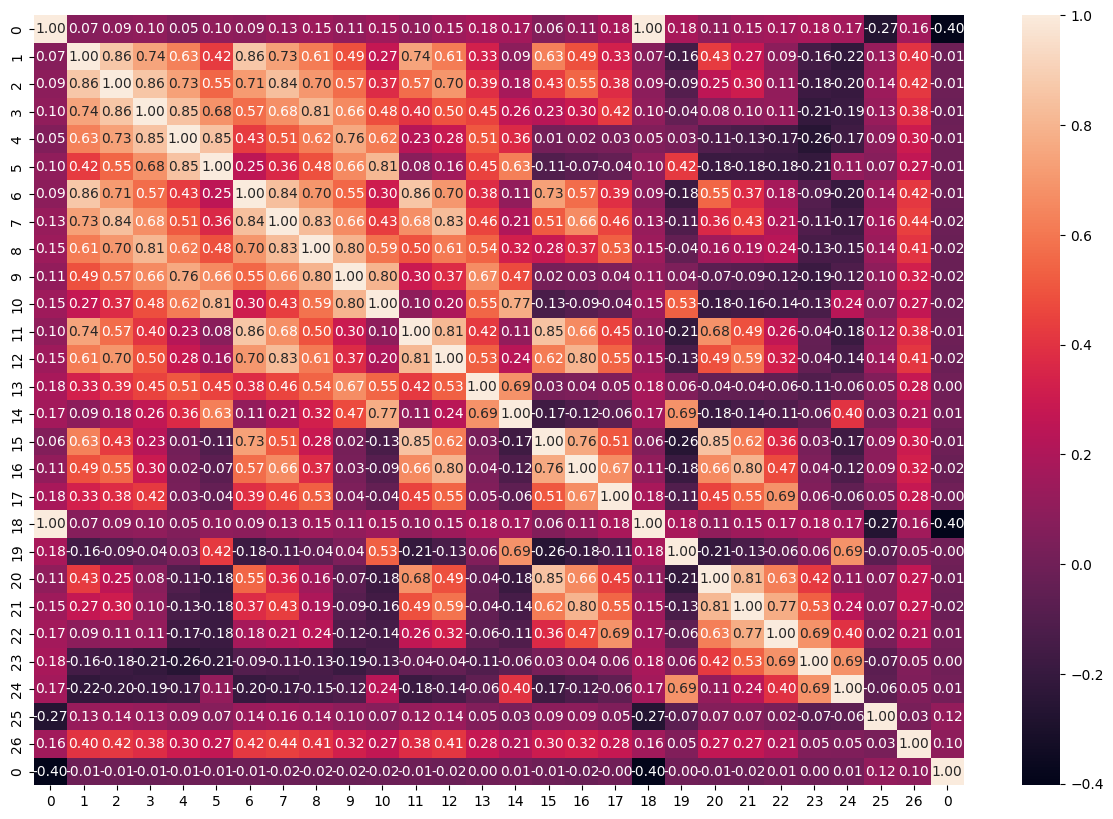

In [ ]:
data = pd.concat([x, y], axis=1)
corr = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot = True, fmt = '.2f')

In [ ]:
spearman_corr = x.corrwith(pd.Series(y.to_numpy().reshape(-1)), method='spearman')
spearman_corr

,0
0,-0.506822
1,-0.007242
2,-0.009958
3,-0.015715
4,-0.008543
5,-0.014362
6,-0.007854
7,-0.025153
8,-0.036283
9,-0.048299


### Try a linear model to identify if the data is linear or non-linear

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2)
y_train = np.array(y_train).reshape((y_train.shape[0]))
y_test = np.array(y_test).reshape((y_test.shape[0]))

# Train a Linear SVM
linear_svm = make_pipeline(StandardScaler(), LinearSVC(dual=False, max_iter=5000))
linear_svm.fit(X_train, y_train)
linear_svm_pred = linear_svm.predict(X_test)

# Evaluate
print("Linear SVM Report:\n", classification_report(y_test, linear_svm_pred))

Linear SVM Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97    141993
           1       1.00      0.58      0.73     20007

    accuracy                           0.95    162000
   macro avg       0.97      0.79      0.85    162000
weighted avg       0.95      0.95      0.94    162000



$\rightarrow$ **Data is likely non-linear because class 1 has a low recall (many false negatives). A linear model struggles to separate it effectively.**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest Report:\n", classification_report(y_test, rf_pred))

Random Forest Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98    141993
           1       0.91      0.72      0.80     20007

    accuracy                           0.96    162000
   macro avg       0.94      0.85      0.89    162000
weighted avg       0.96      0.96      0.95    162000



$\rightarrow$ **Since Random Forest significantly improved recall and F1-score compared to Linear SVM, this strongly suggests that this data has non-linear patterns.**

## Splitting data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
y_train = np.array(y_train).reshape((y_train.shape[0]))
y_test = np.array(y_test).reshape((y_test.shape[0]))
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((648000, 27), (162000, 27), (648000,), (162000,))

## Training

#### Logistic Regression

Try a logistic regression mode, since the problem is binary classification. However, this model may perform poorly because the data is likely not linear.

In [ ]:
lr = LogisticRegression(penalty = 'l1', C=1.0, class_weight='balanced', max_iter=5000)
lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=5000)

In [ ]:
y_pred_lr = lr.predict_proba(X_test)[:, 1]
lr_loss = log_loss(y_test, y_pred_lr)
lr_loss

2.221393979366367

In [ ]:
y_pred_lr = (y_pred_lr >= 0.5).astype(int)
acc_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f'Precision: {precision_lr:.2f}')
print(f'Recall: {recall_lr:.2f}')
print(f'F1: {f1_lr:.2f}\n')

Precision: 0.12
Recall: 0.30
F1: 0.17



<Axes: >

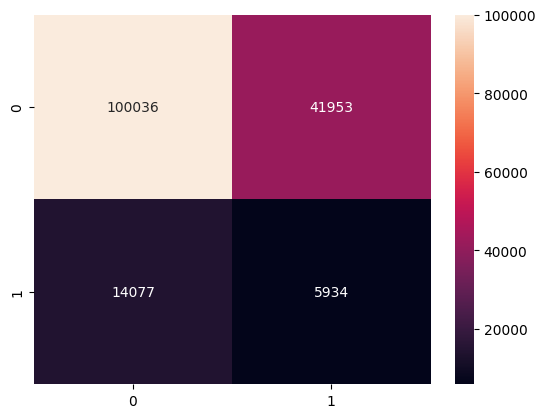

In [ ]:
cmlr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cmlr, annot=True, fmt='g')

The metric shows that the model perform inefficiency. `Logistic regression` is definitely not suitable for this dataset.

#### Decision Tree

Let try a non-linear model to see if it can get a better result.

In [ ]:
dt = DecisionTreeClassifier(criterion = 'entropy', max_features='log2', class_weight='balanced')
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2')

In [ ]:
y_pred_dt= dt.predict(X_test)

mse = mean_squared_error(y_test, y_pred_dt)
print(f"MSE: {mse:.4f}")

MSE: 0.2462


In [ ]:
acc_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print(f'Precision: {precision_dt:.2f}')
print(f'Recall: {recall_dt:.2f}')
print(f'F1: {f1_dt:.2f}\n')

Precision: 0.12
Recall: 0.16
F1: 0.14



<Axes: >

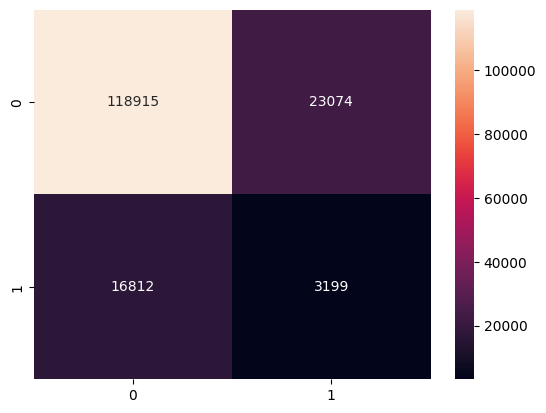

In [ ]:
cmdt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cmdt, annot=True, fmt='g')

(0.0, 1.0)

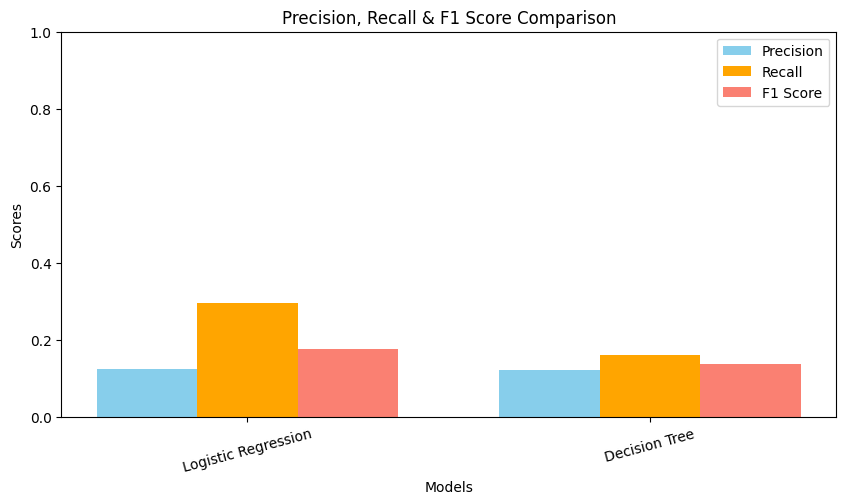

In [ ]:
f1_scores = [f1_lr, f1_dt]
recall_scores = [recall_lr, recall_dt]
precision_scores = [precision_lr, precision_dt]

models = ['Logistic Regression', 'Decision Tree']
bar_width = 0.25
x_labels = models
x = np.arange(len(x_labels))

plt.figure(figsize=(10, 5))

# Plot bars
plt.bar(x - bar_width, precision_scores, bar_width, label="Precision", color="skyblue")
plt.bar(x, recall_scores, bar_width, label="Recall", color="orange")
plt.bar(x + bar_width, f1_scores, bar_width, label="F1 Score", color="salmon")

# Labels & Titles
plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Precision, Recall & F1 Score Comparison")
plt.xticks(x, x_labels, rotation=15)
plt.legend()
plt.ylim(0, 1)


## Improve the models

- Logistic regression fails if the data is `highly non-linear`.\
$\rightarrow$ Using MLP because it works well on highly non-linear data.
- Decision tree fails if the dataset is `complex or high-dimensional`, a single tree may not be enough to learn them effectively.\
$\rightarrow$ Using Random forest because it works well with non-linear relationships. More stable than a single tree.


#### MLPClassifier

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
mlp_improved = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='tanh', max_iter=200, learning_rate='adaptive', learning_rate_init=1e-3, tol=1e-4, verbose=True)
mlp_improved.fit(x_train_scaled, y_train)

Iteration 1, loss = 0.14362960
Iteration 2, loss = 0.13476457
Iteration 3, loss = 0.13189328
Iteration 4, loss = 0.12969122
Iteration 5, loss = 0.12759924
Iteration 6, loss = 0.12570752
Iteration 7, loss = 0.12393916
Iteration 8, loss = 0.12222869
Iteration 9, loss = 0.12070868
Iteration 10, loss = 0.11950293
Iteration 11, loss = 0.11870437
Iteration 12, loss = 0.11814110
Iteration 13, loss = 0.11722531
Iteration 14, loss = 0.11658127
Iteration 15, loss = 0.11630730
Iteration 16, loss = 0.11570512
Iteration 17, loss = 0.11533731
Iteration 18, loss = 0.11482822
Iteration 19, loss = 0.11472218
Iteration 20, loss = 0.11427290
Iteration 21, loss = 0.11398003
Iteration 22, loss = 0.11382642
Iteration 23, loss = 0.11362870
Iteration 24, loss = 0.11337355
Iteration 25, loss = 0.11321144
Iteration 26, loss = 0.11309829
Iteration 27, loss = 0.11279651
Iteration 28, loss = 0.11268523
Iteration 29, loss = 0.11253091
Iteration 30, loss = 0.11230219
Iteration 31, loss = 0.11225828
Iteration 32, los

MLPClassifier(activation='tanh', hidden_layer_sizes=(128, 64, 32),
              learning_rate='adaptive', verbose=True)

best loss: 0.10851220975992229


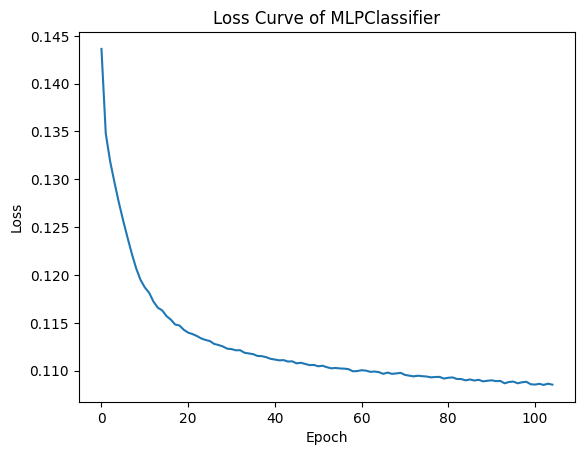

In [ ]:
print(f'best loss: {mlp_improved.best_loss_}')
plt.plot(mlp_improved.loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve of MLPClassifier")
plt.show()

In [ ]:
y_pred_mlp_improved = mlp_improved.predict(x_test_scaled)

acc_mlp_improved = accuracy_score(y_test, y_pred_mlp_improved)
precision_mlp_improved = precision_score(y_test, y_pred_mlp_improved)
recall_mlp_improved = recall_score(y_test, y_pred_mlp_improved)
f1_mlp_improved = f1_score(y_test, y_pred_mlp_improved)

print(f'Precision: {precision_mlp_improved:.2f}')
print(f'Recall: {recall_mlp_improved:.2f}')
print(f'F1: {f1_mlp_improved:.2f}\n')

Precision: 0.95
Recall: 0.71
F1: 0.81



<Axes: >

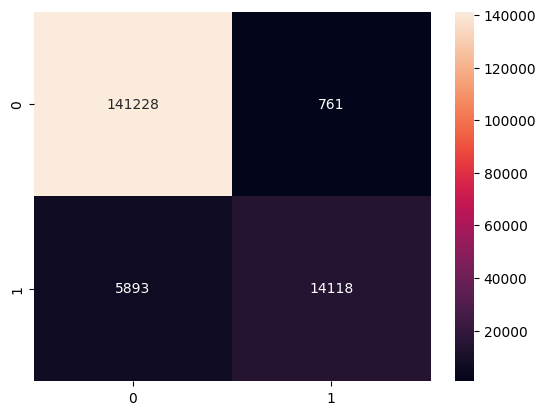

In [ ]:
cmmlp = confusion_matrix(y_test, y_pred_mlp_improved)
sns.heatmap(cmmlp, annot=True, fmt='g')

In [ ]:
crmlp = classification_report(y_test, y_pred_mlp_improved)
print(crmlp)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98    141989
           1       0.93      0.70      0.80     20011

    accuracy                           0.96    162000
   macro avg       0.94      0.85      0.89    162000
weighted avg       0.96      0.96      0.95    162000



#### Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred_rf_improved = rf.predict_proba(x_test)[:, 1]

loss_ = log_loss(y_test, y_pred_rf_improved)
print(f"Log Loss: {loss_:.4f}")

Log Loss: 0.2062


In [ ]:
y_pred_rf_improved = (y_pred_rf_improved >= 0.5).astype(int)

acc_rf_improved = accuracy_score(y_test, y_pred_rf_improved)
precision_rf_improved = precision_score(y_test, y_pred_rf_improved)
recall_rf_improved = recall_score(y_test, y_pred_rf_improved)
f1_rf_improved = f1_score(y_test, y_pred_rf_improved)

print(f'Precision: {precision_rf_improved:.2f}')
print(f'Recall: {recall_rf_improved:.2f}')
print(f'F1: {f1_rf_improved:.2f}\n')

Precision: 0.91
Recall: 0.72
F1: 0.80



<Axes: >

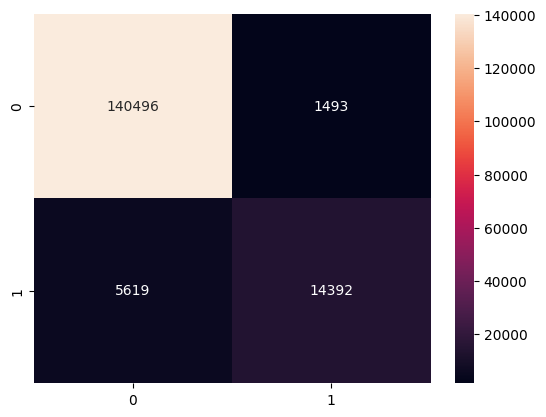

In [ ]:
cmrf = confusion_matrix(y_test, y_pred_rf_improved)
sns.heatmap(cmrf, annot=True, fmt='g')

In [ ]:
crrf = classification_report(y_test, y_pred_rf)
print(crrf)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98    141989
           1       0.91      0.72      0.80     20011

    accuracy                           0.96    162000
   macro avg       0.93      0.85      0.89    162000
weighted avg       0.95      0.96      0.95    162000



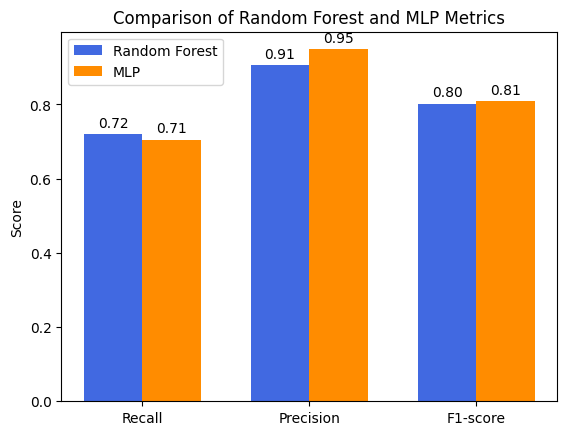

In [ ]:
metrics = ["Recall", "Precision", "F1-score"]
random_forest_scores = [recall_rf_improved, precision_rf_improved, f1_rf_improved]
mlp_scores = [recall_mlp_improved, precision_mlp_improved, f1_mlp_improved]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, random_forest_scores, width, label="Random Forest", color="royalblue")
bars2 = ax.bar(x + width/2, mlp_scores, width, label="MLP", color="darkorange")

# Labels and formatting
ax.set_ylabel("Score")
ax.set_title("Comparison of Random Forest and MLP Metrics")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Show values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset
                    textcoords="offset points",
                    ha='center', va='bottom')

### More information about this project visit via [github repo](https://github.com/nabii-nguyenn213/Minesweeper-Solver/tree/main)